<a href="https://colab.research.google.com/github/Madusha27301/216023H_Lab-Assignment-04/blob/master/216023H_BigData_Individual_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Importing libraries**

In [ ]:
# Install packages
!pip install dask-ml --upgrade
!pip install "dask[complete]" gdown tabulate --quiet

# Data Handling
import pandas as pd          # DataFrames
import numpy as np           # Numbers
import dask.dataframe as dd  # Big data

# Dask & ML
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Utilities
import gdown
from tabulate import tabulate
from IPython.display import display
import warnings


# **2. Loading and Overview of the Dataset**

In [ ]:
# Download the dataset from Google Drive
file_id = "1JeAE5UVTbhlV1k4hxB4n64pGEAMbPYOc"  # Google Drive file ID
dataset_path = "dataset.csv"                   # Local file name
gdown.download(f"https://drive.google.com/uc?id={file_id}", dataset_path, quiet=False)

# Load the dataset using Dask
df = dd.read_csv(dataset_path, assume_missing=True)

# Get the first few rows (head) and last few rows (tail) as Pandas DataFrames
head_df = df.head()
tail_df = df.tail()

# Display the head in a table
print("----- HEAD -----")
print(tabulate(head_df, headers=head_df.columns, tablefmt="fancy_grid", showindex=False))

# Display the tail in a table
print("\n----- TAIL -----")
print(tabulate(tail_df, headers=tail_df.columns, tablefmt="fancy_grid", showindex=False))

# Number of rows
num_rows = df.shape[0].compute()
print("Number of rows:", num_rows)

# Number of columns
num_cols = df.shape[1]  # Columns are known without compute
print("Number of columns:", num_cols)

Downloading...
From (original): https://drive.google.com/uc?id=1JeAE5UVTbhlV1k4hxB4n64pGEAMbPYOc
From (redirected): https://drive.google.com/uc?id=1JeAE5UVTbhlV1k4hxB4n64pGEAMbPYOc&confirm=t&uuid=8c85b651-6492-4843-95c1-1f2fa0106737
To: /content/dataset.csv
100%|██████████| 300M/300M [00:04<00:00, 69.6MB/s]


----- HEAD -----
╒═══════════╤═══════════╤══════════════════╤═══════════╤════════════════╤═══════════════╤══════════════╤══════════════╤═════════╤═══════════════╤═══════════╤══════════╤══════════════╕
│       u_q │   coolant │   stator_winding │       u_d │   stator_tooth │   motor_speed │          i_d │          i_q │      pm │   stator_yoke │   ambient │   torque │   profile_id │
╞═══════════╪═══════════╪══════════════════╪═══════════╪════════════════╪═══════════════╪══════════════╪══════════════╪═════════╪═══════════════╪═══════════╪══════════╪══════════════╡
│ -0.450682 │   18.8052 │          19.0867 │ -0.350055 │        18.2932 │   0.00286557  │  0.00441914  │  0.000328102 │ 24.5542 │       18.3165 │   19.8507 │ 0.187101 │           17 │
├───────────┼───────────┼──────────────────┼───────────┼────────────────┼───────────────┼──────────────┼──────────────┼─────────┼───────────────┼───────────┼──────────┼──────────────┤
│ -0.325737 │   18.8186 │          19.0924 │ -0.305803 │       

# **3. Exploratory Data Analysis (EDA)**

## Checking Data Types

In [ ]:
# Get data types of all columns
column_types = [(col, str(dtype)) for col, dtype in df.dtypes.items()]

# Display as table
print(tabulate(column_types, headers=['Column', 'Data Type'], tablefmt='fancy_grid'))


╒════════════════╤═════════════╕
│ Column         │ Data Type   │
╞════════════════╪═════════════╡
│ u_q            │ float64     │
├────────────────┼─────────────┤
│ coolant        │ float64     │
├────────────────┼─────────────┤
│ stator_winding │ float64     │
├────────────────┼─────────────┤
│ u_d            │ float64     │
├────────────────┼─────────────┤
│ stator_tooth   │ float64     │
├────────────────┼─────────────┤
│ motor_speed    │ float64     │
├────────────────┼─────────────┤
│ i_d            │ float64     │
├────────────────┼─────────────┤
│ i_q            │ float64     │
├────────────────┼─────────────┤
│ pm             │ float64     │
├────────────────┼─────────────┤
│ stator_yoke    │ float64     │
├────────────────┼─────────────┤
│ ambient        │ float64     │
├────────────────┼─────────────┤
│ torque         │ float64     │
├────────────────┼─────────────┤
│ profile_id     │ float64     │
╘════════════════╧═════════════╛


## Descriptive Statistics of Dataset

In [ ]:
# Compute Dask dataframe to get pandas dataframe
df_pandas = df.compute()

# Numerical summary
summary = df_pandas.describe().T

# Add extra statistics
summary['median'] = df_pandas.median()
summary['variance'] = df_pandas.var()
summary['skew'] = df_pandas.skew()
summary['kurtosis'] = df_pandas.kurt()

# Display as a colorful styled table
# Using a colorful diverging colormap
styled_summary = summary.style \
    .background_gradient(cmap='coolwarm', axis=None) \
    .format("{:.2f}") \
    .set_caption("<b>Summary Statistics Table</b>") \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f7f7f7'),
                                     ('color', '#333'),
                                     ('font-size', '12pt')]},
        {'selector': 'td', 'props': [('font-size', '11pt')]}
    ])

display(styled_summary)


,count,mean,std,min,25%,50%,75%,max,median,variance,skew,kurtosis
u_q,1330816.00,54.28,44.17,-25.29,12.07,48.94,90.03,133.04,48.94,1951.27,0.31,-1.24
coolant,1330816.00,36.23,21.79,10.62,18.70,26.90,49.86,101.60,26.90,474.64,1.05,-0.10
stator_winding,1330816.00,66.34,28.67,18.59,42.79,65.11,88.14,141.36,65.11,822.09,0.17,-0.90
u_d,1330816.00,-25.13,63.09,-131.53,-78.69,-7.43,1.47,131.47,-7.43,3980.60,0.15,-0.29
stator_tooth,1330816.00,56.88,22.95,18.13,38.42,56.04,75.59,111.95,56.04,526.81,0.14,-0.99
motor_speed,1330816.00,2202.08,1859.66,-275.55,317.11,1999.98,3760.64,6000.02,1999.98,3458347.78,0.39,-1.15
i_d,1330816.00,-68.72,64.93,-278.00,-115.41,-51.09,-2.98,0.05,-51.09,4216.32,-0.71,-0.57
i_q,1330816.00,37.41,92.18,-293.43,1.10,15.77,100.61,301.71,15.77,8497.50,-0.15,0.68
pm,1330816.00,58.51,19.00,20.86,43.15,60.27,72.01,113.61,60.27,361.06,0.04,-0.75
stator_yoke,1330816.00,48.19,19.99,18.08,31.99,45.63,61.46,101.15,45.63,399.64,0.48,-0.63


## Checking for Missing Values

In [ ]:
# Check for null values per column
null_counts = df.isnull().sum().compute()  # convert to Pandas Series
print("----- NULL VALUES PER COLUMN -----\n")
print(null_counts)

----- NULL VALUES PER COLUMN -----

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64


## Checking for Duplicate Records

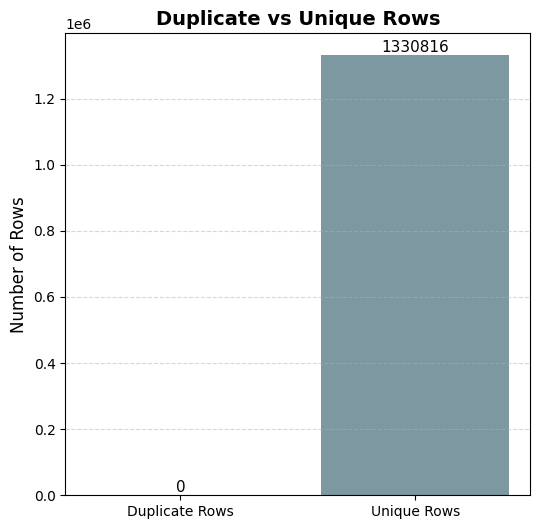

In [ ]:
# Duplicate rows
duplicate_count = df.map_partitions(lambda pdf: pdf.duplicated()).sum().compute()
unique_count = len(df.compute()) - duplicate_count

labels = ["Duplicate Rows", "Unique Rows"]
values = [duplicate_count, unique_count]

plt.figure(figsize=(6,6))

# Pastel colors
colors = ['#A3C1AD', '#7D98A1']  # soft green for duplicates, soft blue for unique

bars = plt.bar(labels, values, color=colors)
plt.ylabel("Number of Rows", fontsize=12)
plt.title("Duplicate vs Unique Rows", fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, f'{int(height)}',
             ha='center', va='bottom', fontsize=11)

plt.show()

# Checking Outliers in Each Feature

In [ ]:
# Compute outlier counts for all columns in the DataFrame
outlier_counts = {}

for col in df.columns:
    # Skip non-numeric columns (like 'id' if it's categorical)
    if not np.issubdtype(df[col].dtype, np.number):
        continue

    # Compute quartiles
    q1, q3 = df[col].quantile([0.25, 0.75]).compute()
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Count outliers
    count = df[(df[col] < lower) | (df[col] > upper)][col].count().compute()
    outlier_counts[col] = count

# Print results
print("----- OUTLIER COUNTS -----\n")
for k, v in outlier_counts.items():
    print(f"{k}: {v}")

----- OUTLIER COUNTS -----

u_q: 0
coolant: 0
stator_winding: 16
u_d: 0
stator_tooth: 0
motor_speed: 0
i_d: 799
i_q: 21069
pm: 234384
stator_yoke: 0
ambient: 12
torque: 27149
profile_id: 0


# Box Plots of Feature Outliers

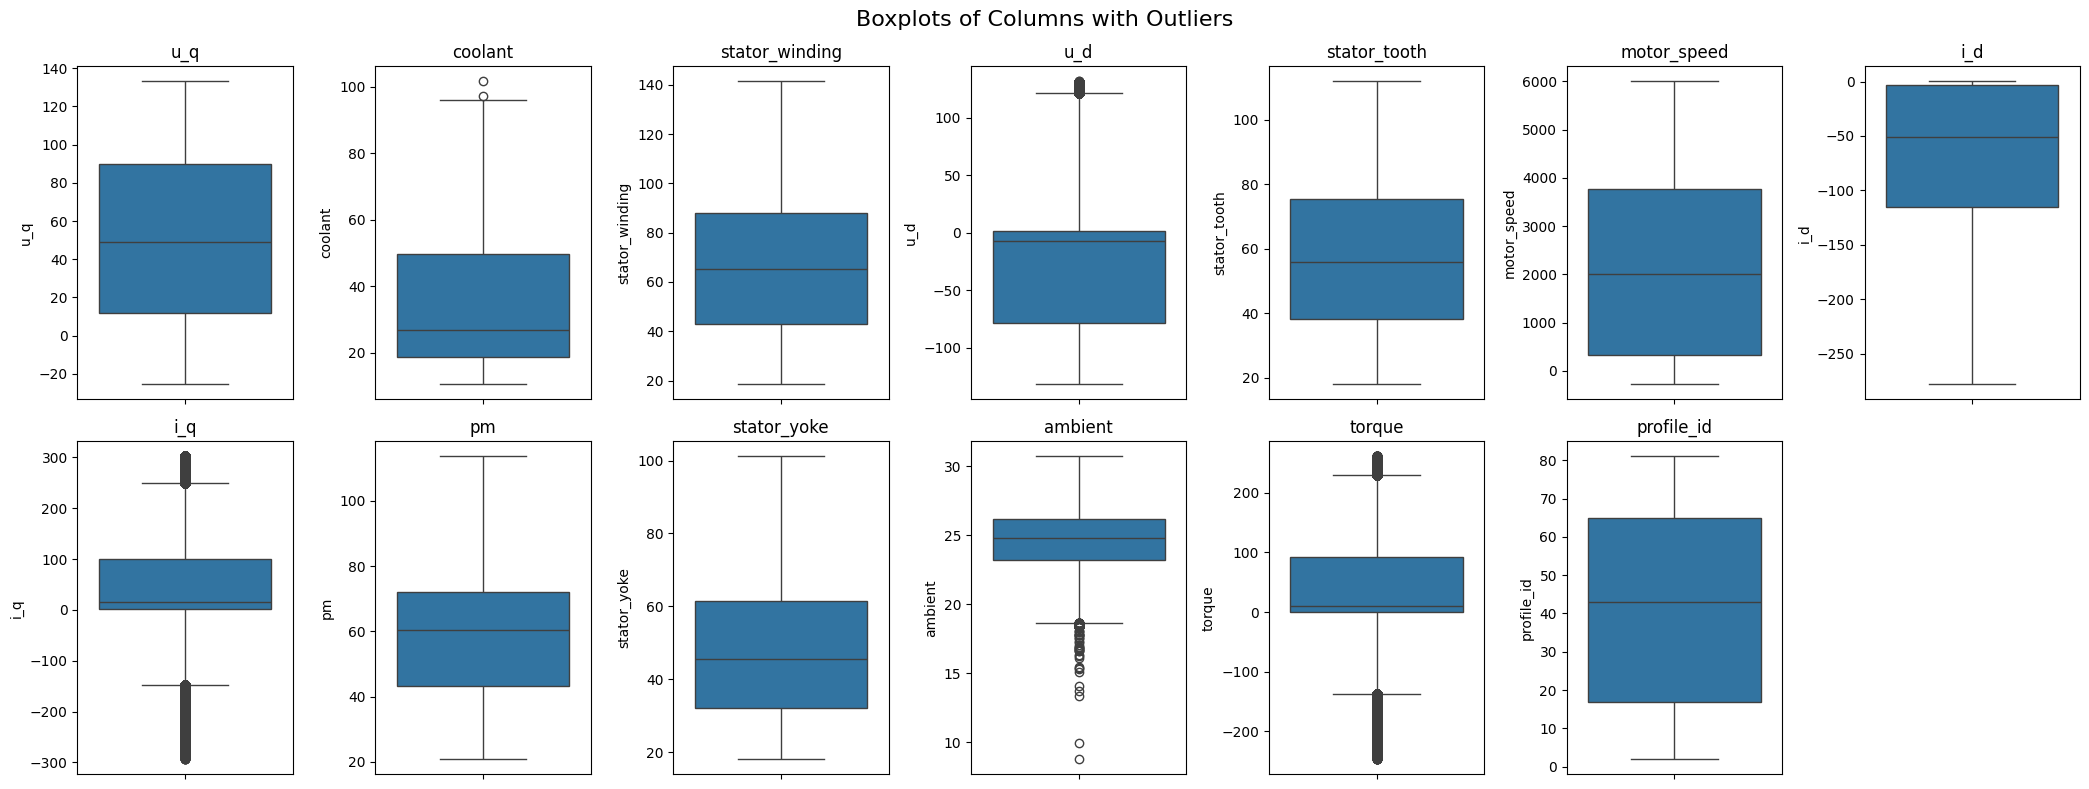

In [ ]:
# 1. Select numeric columns
numeric_cols = df.select_dtypes(include=['float64']).columns.tolist()

# 2. Create a copy of Dask dataframe to mark outliers
df_out = df.copy()

# 3. Mark outliers per column using IQR
for col in numeric_cols:
    q1, q3 = df[col].quantile([0.25, 0.75]).compute()
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Create boolean series for outliers
    df_out[col + '_outlier'] = ((df[col] < lower) | (df[col] > upper))

# 4. Compute full dataset for plotting
df_full = df_out.compute()  # this converts Dask to Pandas

# 5. Plot boxplots for all numeric columns
cols_per_row = 7
num_rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(cols_per_row*3, num_rows*4))

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, cols_per_row, i+1)
    sns.boxplot(y=df_full[col])
    plt.title(col)

plt.suptitle('Boxplots of Columns with Outliers', fontsize=16)
plt.tight_layout()
plt.show()

# Feature Correlation Heatmap

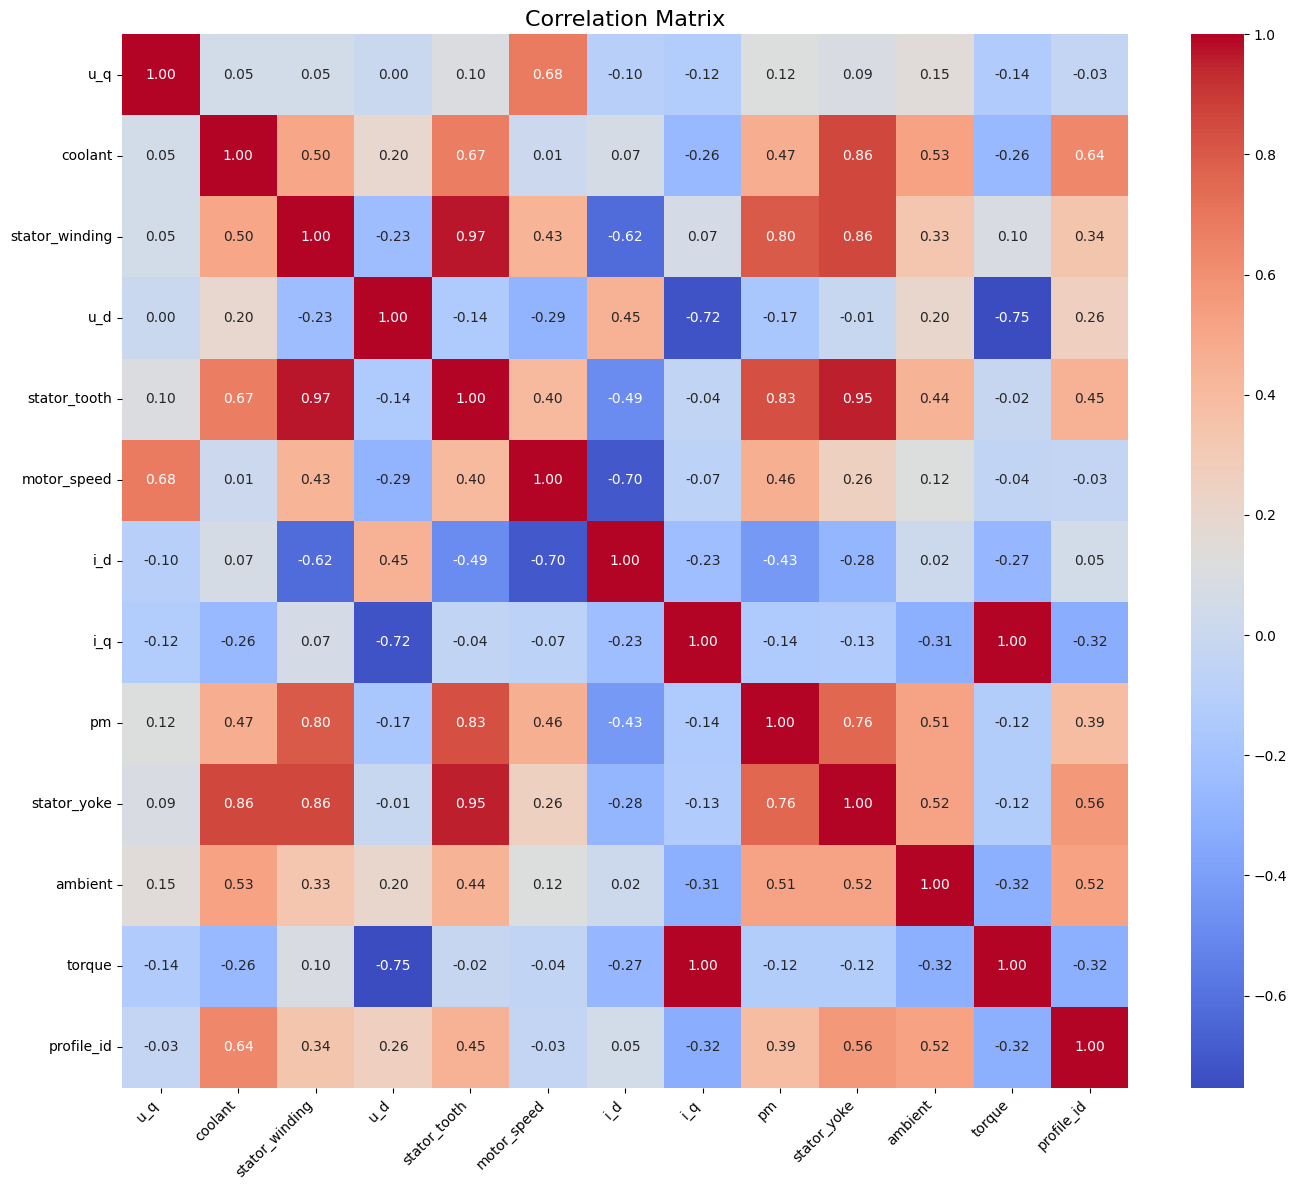

In [ ]:
# Compute correlation matrix for all numeric columns
corr_matrix = df.select_dtypes(include=['float64']).corr().compute()

# Visualize correlation matrix with proper labels
plt.figure(figsize=(14,12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()


# Histogram Analysis of Features

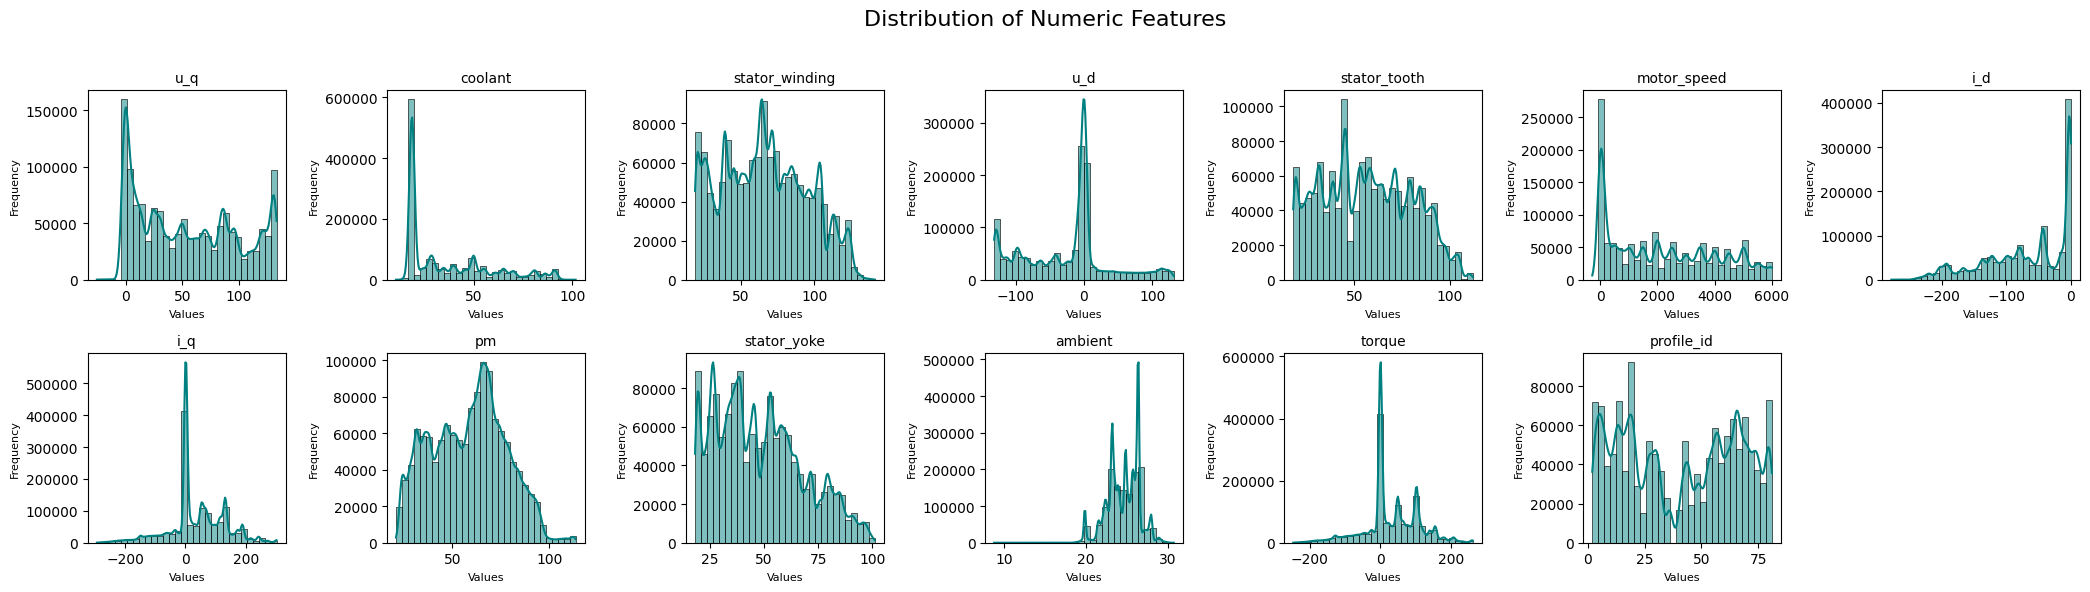

In [ ]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=['float64']).columns.tolist()


# Set number of plots per row
cols_per_row = 7
num_rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row


# Create figure

plt.figure(figsize=(cols_per_row*3, num_rows*3))

# Plot histograms for each numeric column

for i, col in enumerate(numeric_cols):
    plt.subplot(num_rows, cols_per_row, i+1)
    sns.histplot(df[col].compute(), kde=True, color='teal', bins=30)  # compute Dask series
    plt.title(col, fontsize=10)
    plt.xlabel('Values', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)

# Add overall figure title

plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


# Pie Chart of Session Durations

In [ ]:

# Each row is 0.5 seconds (2 Hz), so duration in hours = counts * 0.5 / 3600
session_duration = df['profile_id'].value_counts() * 0.5 / 3600
session_duration = session_duration.compute()

# Bin session durations into intervals (1-hour bins)
bins = [0, 1, 2, 3, 4, 5, 6, session_duration.max()+1]
labels = ["0-1 hr", "1-2 hr", "2-3 hr", "3-4 hr", "4-5 hr", "5-6 hr", ">6 hr"]
session_binned = pd.cut(session_duration, bins=bins, labels=labels, right=False)
hour_counts = session_binned.value_counts().sort_index()


# Prepare colors
colors = ['#007EA7', '#FF6F61', '#6A994E', '#F2C14E', '#8E5572', '#4B4453', '#A0C4FF']

# Build Pie Chart
pull_values = [0.05 if v == hour_counts.max() else 0 for v in hour_counts.values]

fig = go.Figure(
    data=[go.Pie(
        labels=hour_counts.index,
        values=hour_counts.values,
        textinfo='percent+label',
        textfont=dict(size=14, color='black'),
        textposition='outside',
        marker=dict(colors=colors[:len(hour_counts)], line=dict(color='white', width=2)),
        pull=pull_values,
        hovertemplate="<b>%{label}</b><br>Sessions: %{value}<br>Percentage: %{percent}<extra></extra>"
    )]
)

# 5. Layout styling
fig.update_layout(
    title=dict(
        text="Session Duration Distribution by Hour",
        font=dict(size=20, family="Arial", color="black"),
        x=0.5, xanchor='center'
    ),
    width=700,
    height=700,
    margin=dict(t=80, b=40, l=40, r=40),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=True  # enable legend for clarity
)

fig.show()

## Distribution of Measurement Sessions

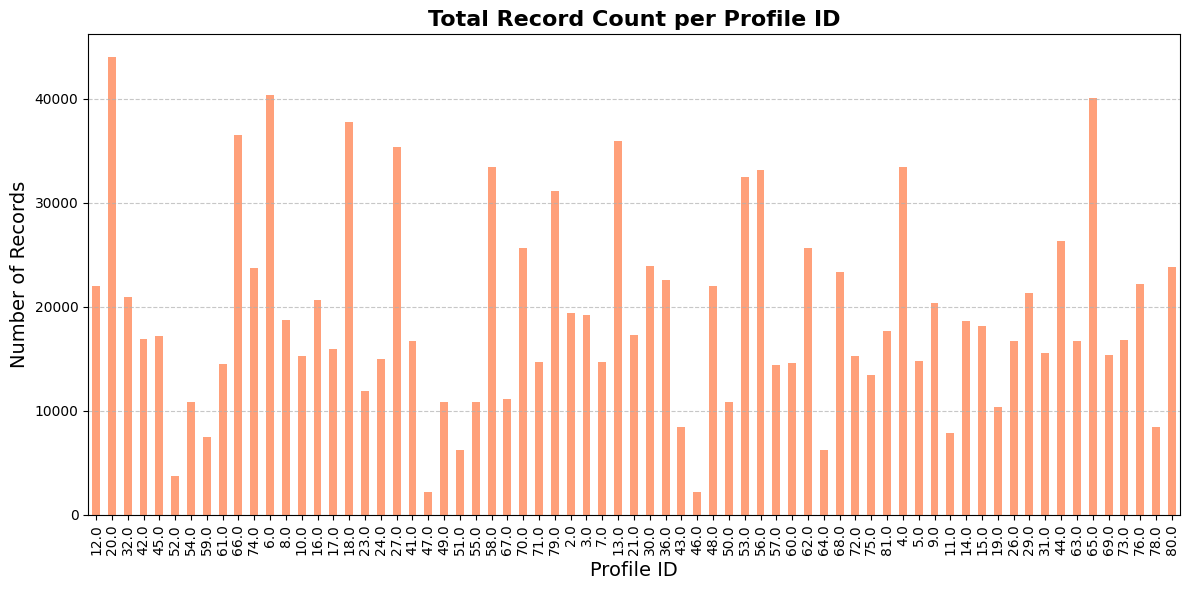

In [ ]:
# Check if df_capped_full is a Dask DataFrame
if hasattr(df, "compute"):
    # Dask: compute value counts
    id_counts = df['profile_id'].value_counts().compute()
else:
    # Pandas: directly use value_counts
    id_counts = df['profile_id'].value_counts()

# Plot as a bar chart
plt.figure(figsize=(12, 6))
id_counts.plot(kind='bar', color='#FFA07A')  # Soft pastel orange
plt.title('Total Record Count per Profile ID', fontsize=16, fontweight='bold')
plt.xlabel('Profile ID', fontsize=14)
plt.ylabel('Number of Records', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Motor Performance Trends with Speed

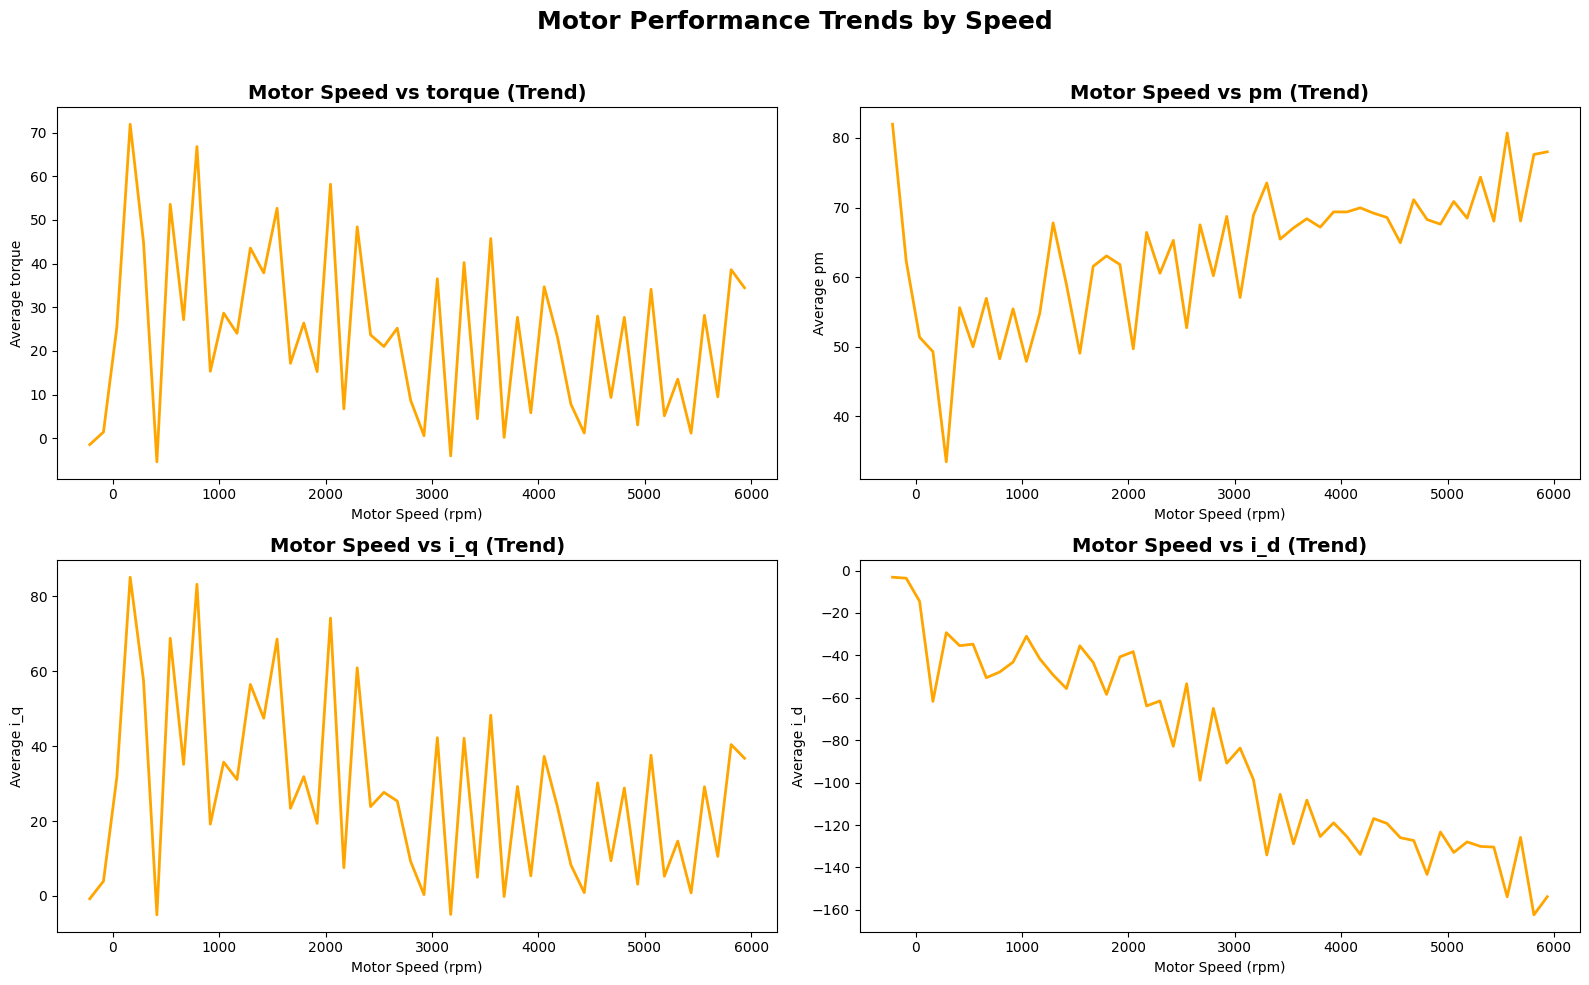

In [ ]:
# Columns to compare with motor speed
cols_to_compare = ['torque', 'pm', 'i_q', 'i_d']

# Sample only the necessary columns and compute (safe for big data)
plot_df = df[['motor_speed'] + cols_to_compare].compute()  # convert Dask to Pandas

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2x2 grid
axes = axes.flatten()  # flatten axes for easy iteration

# Plot trends of each variable vs speed
for i, col in enumerate(cols_to_compare):
    # Bin motor speed into 50 equal intervals
    plot_df['speed_bin'] = pd.cut(plot_df['motor_speed'], bins=50)

    # Compute average of the column per speed bin
    avg_values = plot_df.groupby('speed_bin', observed=False)[col].mean()

    # Use midpoint of each bin for x-axis
    bin_centers = [interval.mid for interval in avg_values.index]

    # Plot the trend
    axes[i].plot(bin_centers, avg_values.values, color='orange', lw=2)
    axes[i].set_title(f"Motor Speed vs {col} (Trend)", fontsize=14, weight='bold')
    axes[i].set_xlabel("Motor Speed (rpm)")
    axes[i].set_ylabel(f"Average {col}")

# Add overall figure title
plt.suptitle("Motor Performance Trends by Speed", fontsize=18,weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()

## Motor Measurement Averages by Category Range

/tmp/ipython-input-676801101.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



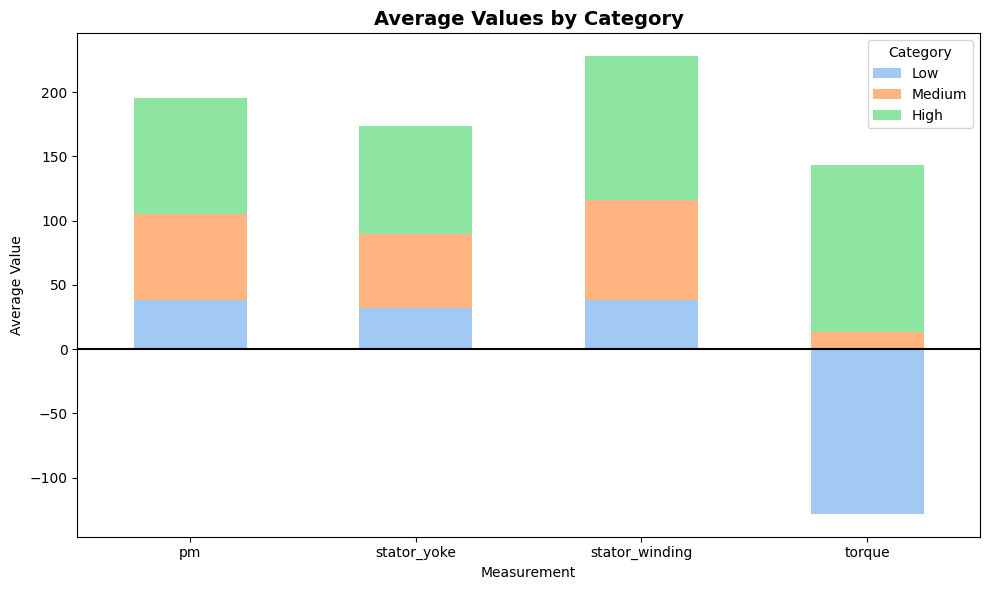

In [ ]:
# Convert Dask DataFrame to Pandas first
df_plot = df.compute().copy()

# Bin temperatures and torque into 3 categories: Low, Medium, High
columns_to_bin = ['pm', 'stator_yoke', 'stator_winding', 'torque']
for col in columns_to_bin:
    df_plot[col + '_cat'] = pd.cut(
        df_plot[col],
        bins=3,
        labels=['Low', 'Medium', 'High']
    )

# Compute average values grouped by category
avg_data = {}
for col in columns_to_bin:
    avg_values = df_plot.groupby(col + '_cat')[col].mean()
    avg_data[col] = avg_values

# Create a DataFrame for plotting
avg_df = pd.DataFrame(avg_data)
avg_df = avg_df.T  # transpose so rows are variables, columns are categories

# Plot stacked column chart
ax = avg_df.plot(kind='bar', stacked=True, figsize=(10, 6),
                 color=['#A1C9F4', '#FFB482', '#8DE5A1'])

# Add black horizontal line at y=0
plt.axhline(0, color='black', linewidth=1.5)

plt.title('Average Values by Category', fontsize=14, weight='bold')
plt.xlabel('Measurement')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

## Proportion of Motor Measurements by Category

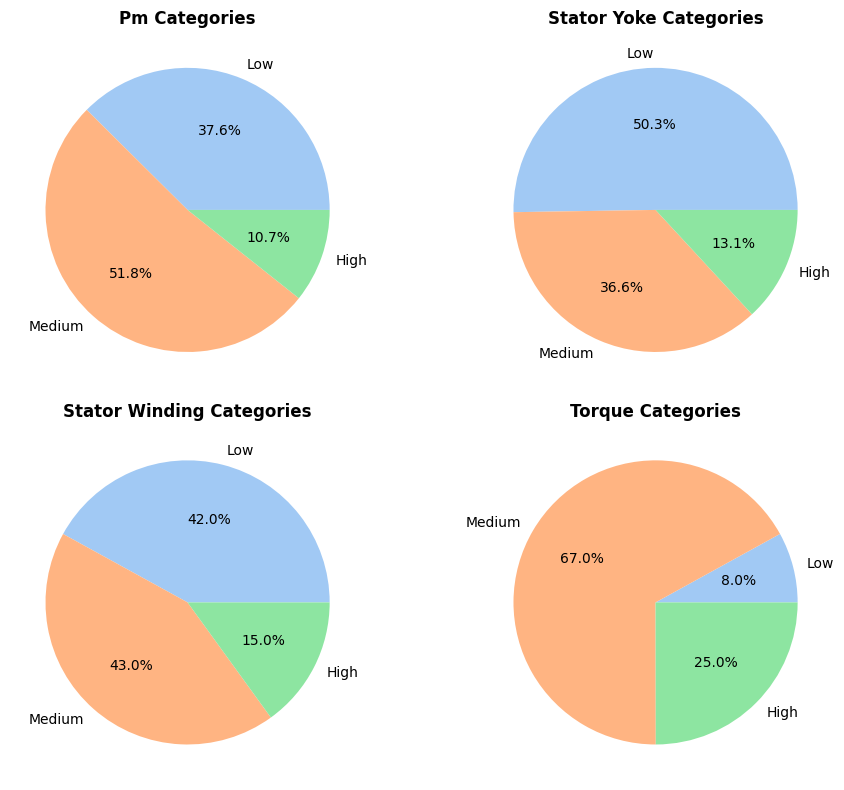

In [ ]:
# Copy dataframe
df_plot_ = df.copy()

# Bin temperatures and torque into 3 categories: Low, Medium, High
columns_to_bin = ['pm', 'stator_yoke', 'stator_winding', 'torque']
for col in columns_to_bin:
    df_plot[col + '_cat'] = pd.cut(
        df_plot[col],
        bins=3,
        labels=['Low', 'Medium', 'High']
    )

# Eye-pleasing pastel colors
colors = ['#A1C9F4', '#FFB482', '#8DE5A1']  # blue, orange, green

# Smaller figure: 2 rows × 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # reduced size
axes = axes.flatten()

# Plot pie charts for each category
for i, col in enumerate(columns_to_bin):
    counts = df_plot[col + '_cat'].value_counts().sort_index()
    axes[i].pie(
        counts.values,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=colors,
        textprops={'fontsize': 10}
    )
    axes[i].set_title(f'{col.replace("_"," ").title()} Categories', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

## Trend of Motor Variables Over Time

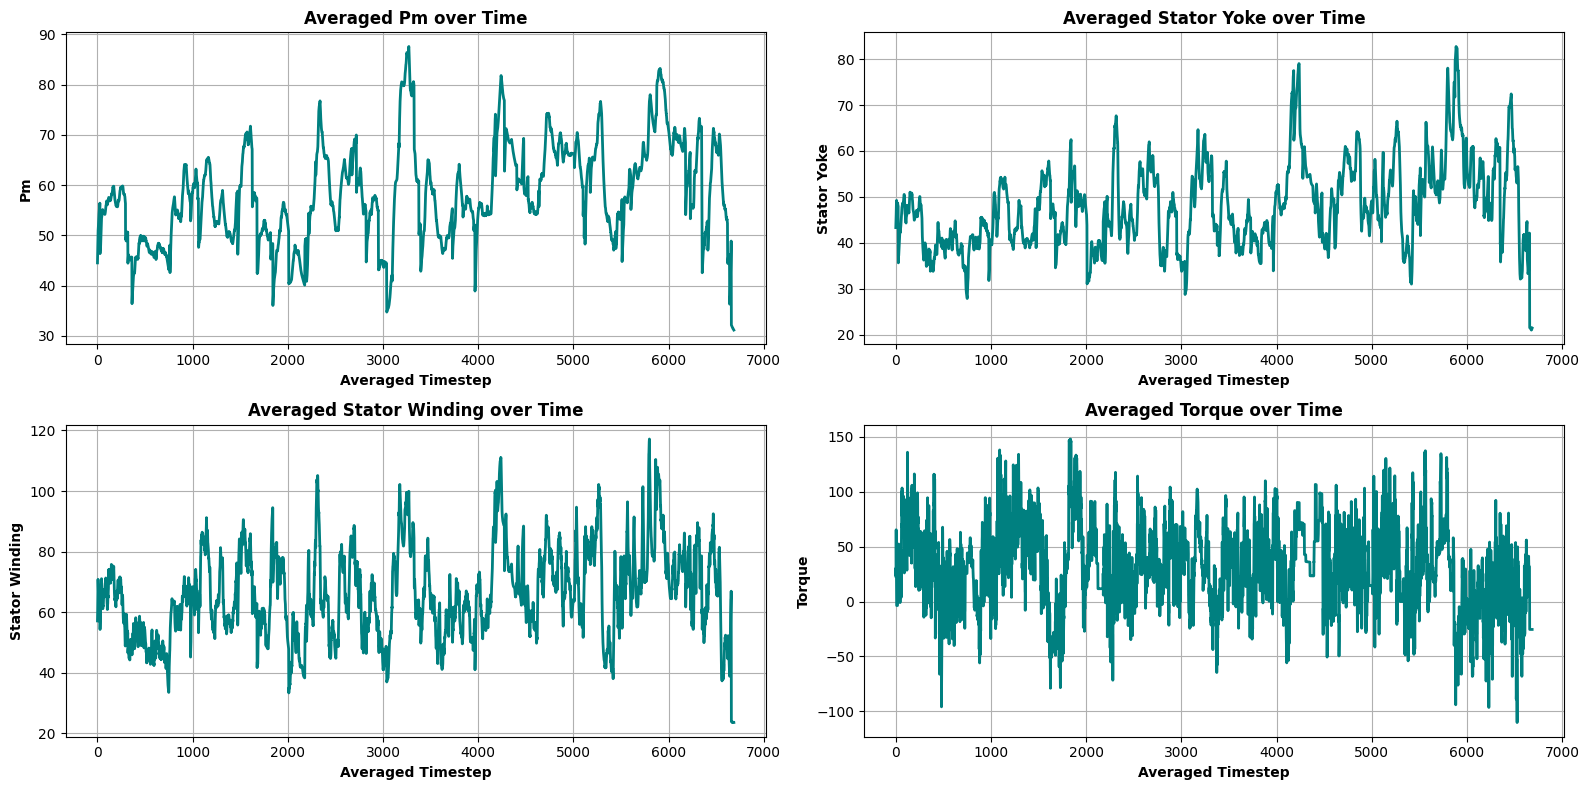

In [ ]:
# Columns to analyze
cols_to_plot = ['pm', 'stator_yoke', 'stator_winding', 'torque']

# Define a window size for grouping (e.g., 50 rows per average)
window_size = 50

# Convert Dask DataFrame to Pandas DataFrame
df_pd = df[cols_to_plot].compute()

# Aggregate data by averaging every `window_size` rows
df_avg = df_pd.groupby(df_pd.index // window_size).mean()

# Plot
num_cols = 2
num_rows = (len(cols_to_plot) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    axes[i].plot(df_avg[col], color='teal', linewidth=2)
    axes[i].set_xlabel("Averaged Timestep", weight="bold")
    axes[i].set_ylabel(col.replace('_', ' ').title(), weight="bold")
    axes[i].grid(True)
    axes[i].set_title(f"Averaged {col.replace('_', ' ').title()} over Time", weight="bold")

# Hide any empty subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Feature Relationships and Interactions in Bubble Plots

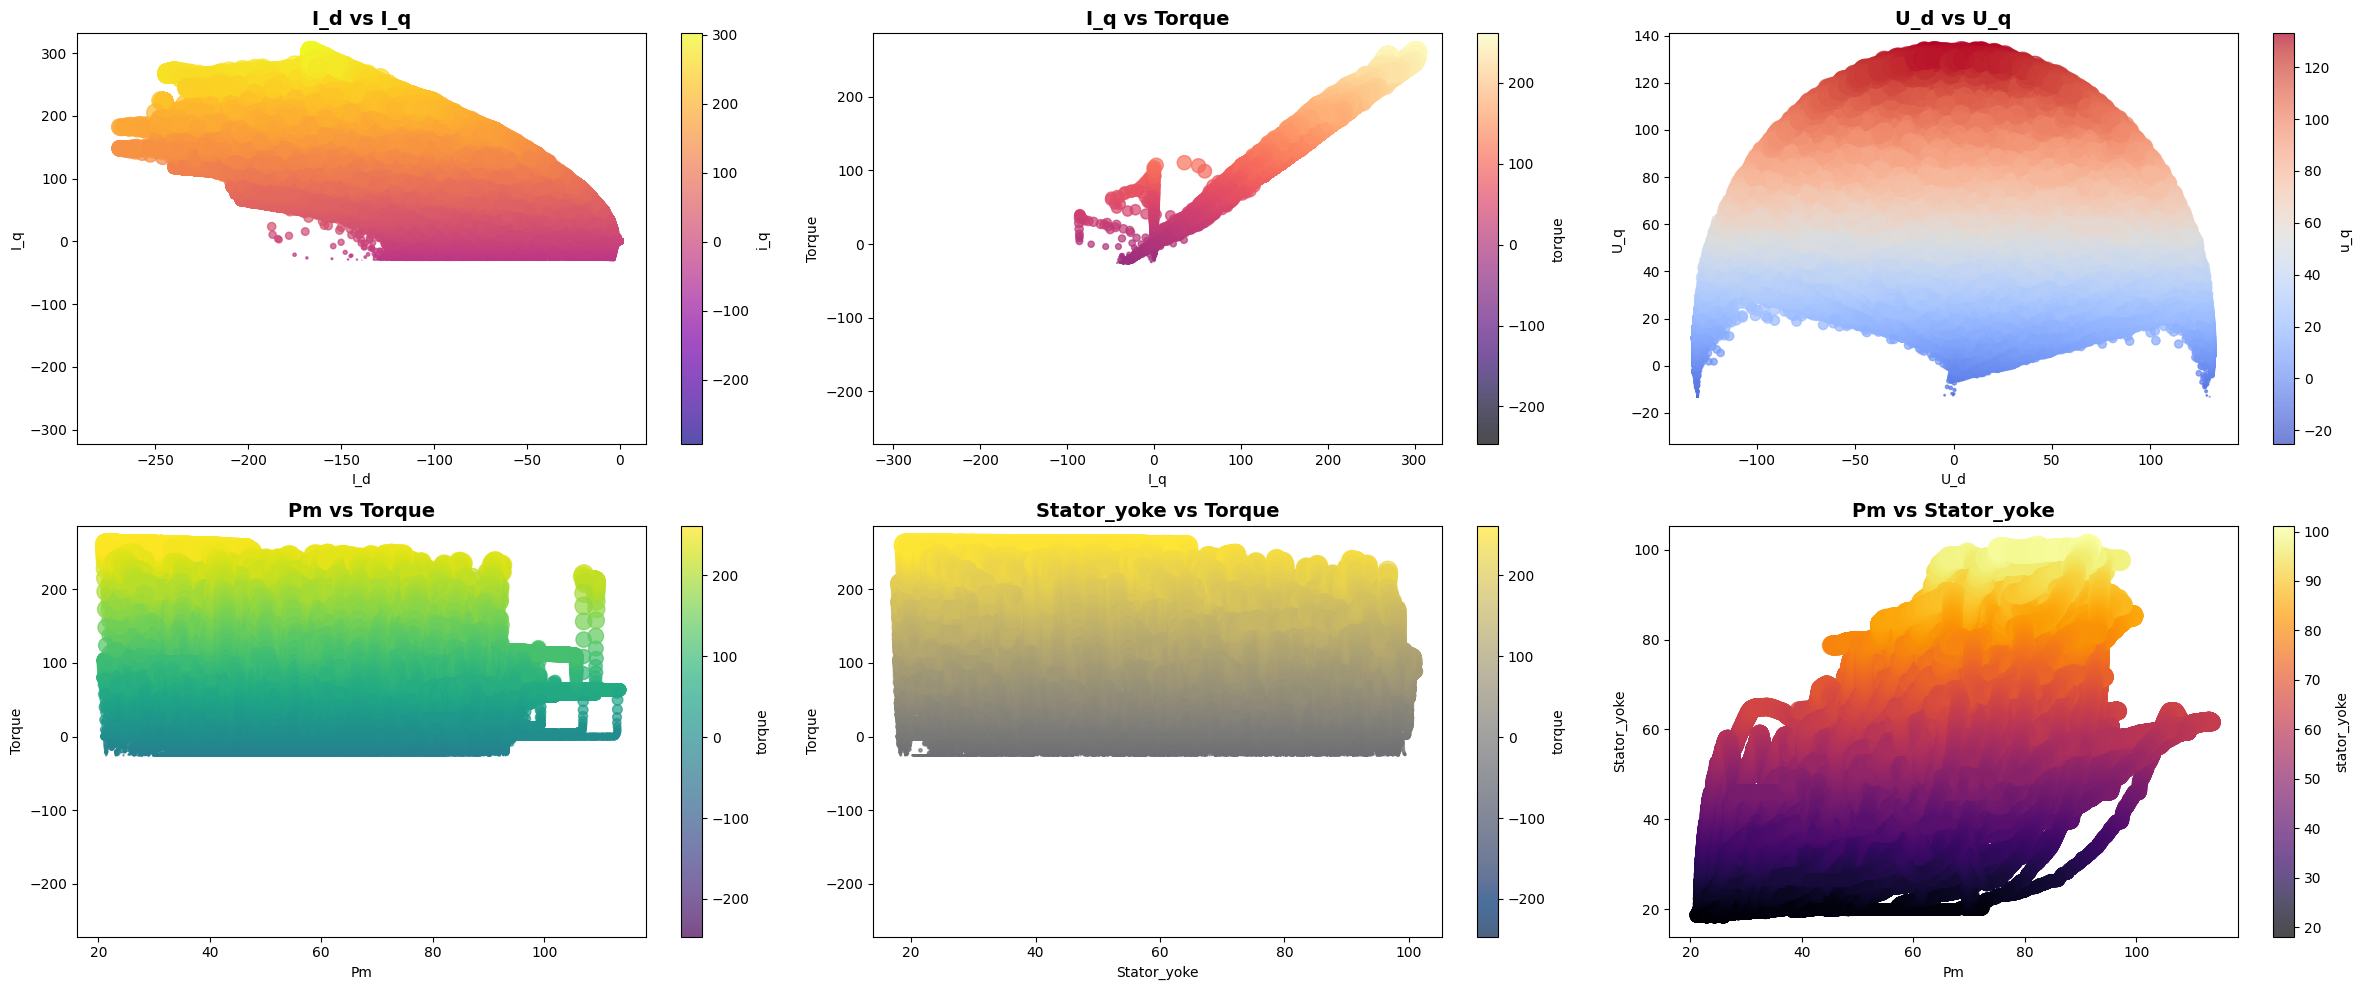

In [ ]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Use full capped dataset
df_plot = df

# If df is a Dask DataFrame, convert to Pandas
if hasattr(df_plot, "compute"):
    df_plot = df_plot.compute()

# Define the 6 most relevant plots (x_col, y_col, colormap, color_label)
plot_info = [
    ('i_d', 'i_q', 'plasma', 'i_q'),
    ('i_q', 'torque', 'magma', 'torque'),
    ('u_d', 'u_q', 'coolwarm', 'u_q'),
    ('pm', 'torque', 'viridis', 'torque'),
    ('stator_yoke', 'torque', 'cividis', 'torque'),
    ('pm', 'stator_yoke', 'inferno', 'stator_yoke')
]

# Figure setup: 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(24, 10))
axes = axes.flatten()  # Flatten for easy iteration

for i, (x_col, y_col, cmap, c_label) in enumerate(plot_info):
    # Bubble size proportional to y_col
    sizes = (df_plot[y_col] / df_plot[y_col].max() * 200) + 20
    scatter = axes[i].scatter(
        df_plot[x_col], df_plot[y_col],
        c=df_plot[y_col], cmap=cmap, s=sizes, alpha=0.7
    )
    axes[i].set_title(f"{x_col.capitalize()} vs {y_col.capitalize()}", fontsize=14, weight='bold')
    axes[i].set_xlabel(x_col.capitalize())
    axes[i].set_ylabel(y_col.capitalize())
    cbar = fig.colorbar(scatter, ax=axes[i])
    cbar.set_label(c_label)

plt.tight_layout()
plt.show()


# **4.Data Preprocessing**

## Boxplot Visualization After Outlier Treatment

Columns with outliers: ['stator_winding', 'i_d', 'i_q', 'pm', 'ambient', 'torque']


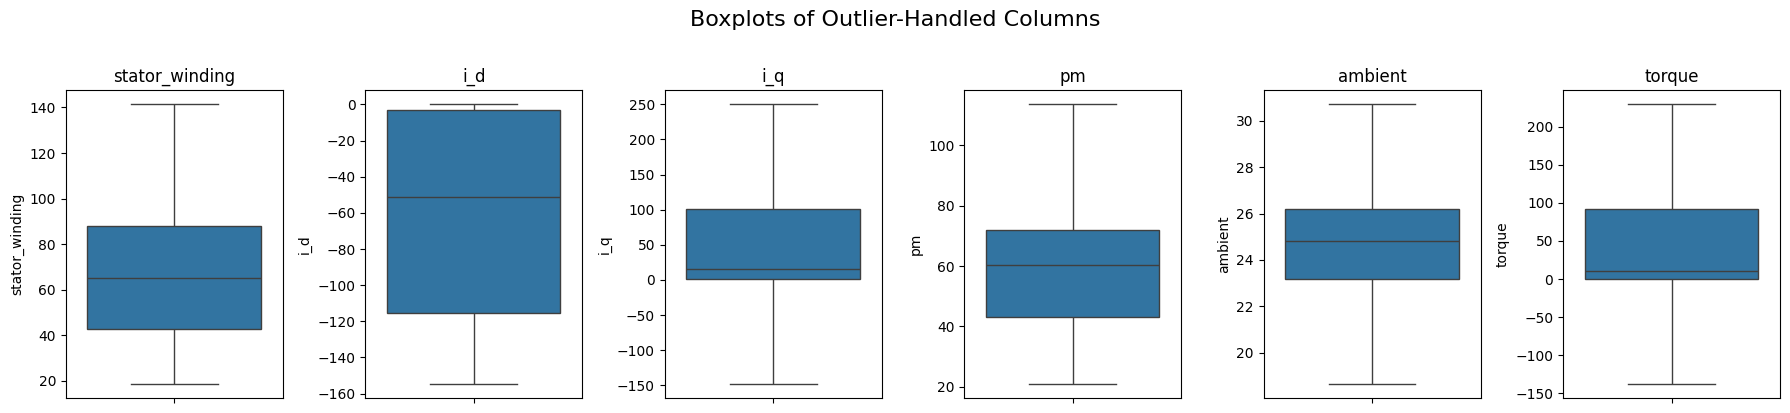

In [ ]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=['float64']).columns.tolist()

# Find columns with outliers
cols_with_outliers = []
for col in numeric_cols:
    q1, q3 = df[col].quantile([0.25, 0.75]).compute()
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    # Count outliers
    outlier_count = df[(df[col] < lower) | (df[col] > upper)][col].count().compute()
    if outlier_count > 0:
        cols_with_outliers.append(col)

print("Columns with outliers:", cols_with_outliers)

# Cap outliers only in those columns
df_capped = df.copy()
for col in cols_with_outliers:
    q1, q3 = df_capped[col].quantile([0.25, 0.75]).compute()
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df_capped[col] = df_capped[col].map_partitions(lambda s: s.clip(lower=lower, upper=upper).astype(float))
    mean_val = df_capped[col].mean().compute()
    df_capped[col] = df_capped[col].fillna(mean_val).astype(float)

# Compute full dataset
df_capped_full = df_capped.compute()

# Plot boxplots for only outlier-affected columns
cols_per_row = 6
num_rows = (len(cols_with_outliers) + cols_per_row - 1) // cols_per_row
plt.figure(figsize=(cols_per_row * 3, num_rows * 4))

for i, col in enumerate(cols_with_outliers):
    plt.subplot(num_rows, cols_per_row, i + 1)
    sns.boxplot(y=df_capped_full[col], showfliers=False, orient='v')
    plt.title(col)

# Add a main title
plt.suptitle("Boxplots of Outlier-Handled Columns", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()


## Funnel Chart of Engineered Feature Categories

In [ ]:
# Make a copy of the original df
df_feat = df.copy()  # keep original df untouched


# Convert Dask to Pandas if needed
if 'dask' in str(type(df_feat)):
    df_feat = df_feat.compute()

# Create engineered features
df_feat['motor_load_factor'] = df_feat['torque'] / (df_feat['motor_speed'] + 1e-6)
df_feat['current_interaction'] = df_feat['i_d'] * df_feat['i_q']
df_feat['thermal_stress_index'] = (
    df_feat['pm'] + df_feat['stator_tooth'] + df_feat['stator_yoke'] + df_feat['coolant']
)/4 - df_feat['ambient']

# Categorize features with manual bins
labels = ['Low','Medium','High']

mlf_bins = [-float('inf'), 0.5, 1.5, float('inf')]
ci_bins = [-float('inf'), 5, 20, float('inf')]
tsi_bins = [-float('inf'), 200, 400, float('inf')]

df_feat['motor_load_factor_cat'] = pd.cut(df_feat['motor_load_factor'], bins=mlf_bins, labels=labels)
df_feat['current_interaction_cat'] = pd.cut(df_feat['current_interaction'], bins=ci_bins, labels=labels)
df_feat['thermal_stress_index_cat'] = pd.cut(df_feat['thermal_stress_index'], bins=tsi_bins, labels=labels)

# 5Aggregate counts for funnel chart
funnel_data = []
cat_features = ['motor_load_factor_cat','current_interaction_cat','thermal_stress_index_cat']

for feature in cat_features:
    counts = df_feat[feature].value_counts()
    for cat in labels:
        funnel_data.append({
            'Feature': feature.replace('_cat','').replace('_',' ').title(),
            'Category': cat,
            'Count': counts.get(cat,0)
        })

funnel_df = pd.DataFrame(funnel_data)

# Plot funnel chart
fig = px.funnel(
    funnel_df,
    x='Count',
    y='Feature',
    color='Category',
    category_orders={'Category':['Low','Medium','High']},
    color_discrete_map={'Low':'#007EA7', 'Medium':'#6A994E', 'High':'#FF6F61'},
    title='Engineered Feature Categories Funnel Chart'
)

fig.update_layout(
    xaxis_title='Count of Records',
    yaxis_title='Feature',
    template='plotly_white'
)

fig.show()

## Thermal Stress Index Over Time

In [ ]:
# Line chart with axis labels
fig = px.line(
    df_feat.head(5000),
    y='thermal_stress_index',
    title='Thermal Stress Over Time (Sample)',
    labels={
        'index': 'Time (Samples)',
        'thermal_stress_index': 'Thermal Stress Index (°C Difference)'
    }
)

fig.update_layout(
    xaxis_title='Time (Samples)',
    yaxis_title='Thermal Stress Index (°C Difference)'
)

fig.show()

## Random Sample of Feature Engineering Results

In [ ]:
# Take a sample of 10 rows from engineered features
sample_cols = [
    'motor_load_factor', 'motor_load_factor_cat',
    'current_interaction', 'current_interaction_cat',
    'thermal_stress_index', 'thermal_stress_index_cat'
]

# Randomly sample 10 rows
sample_df = df_feat[sample_cols].sample(n=10, random_state=42)

# Display as a table
import IPython.display as display
display.display(sample_df)


,motor_load_factor,motor_load_factor_cat,current_interaction,current_interaction_cat,thermal_stress_index,thermal_stress_index_cat
294684,9.502830e-03,Low,-7180.769554,Low,55.848526,Low
1605,1.500012e-02,Low,-15696.435098,Low,45.538086,Low
327252,-1.683778e-02,Low,12197.013968,High,25.521273,Low
212054,9.977317e-02,Low,-1096.884017,Low,50.861795,Low
75406,1.778597e-02,Low,-16060.862461,Low,34.313289,Low
93605,2.068500e+00,High,-29811.679102,Low,21.520375,Low
91754,4.272794e-01,Low,-26409.221016,Low,49.064382,Low
39413,5.090923e-02,Low,-5770.583949,Low,12.008313,Low
88289,-3.585337e-02,Low,19981.281083,High,35.384114,Low
61964,1.792136e-317,Low,-2.193661,Low,22.979397,Low


## Dropping Profile ID Column

In [ ]:
# Drop the 'id' column
df_capped = df_capped.drop(columns=['profile_id'])

## Train-Test Split for Model Training

In [ ]:
# Preprocessing & Train-Test Split
# Start Dask Client
client = Client()

# Use preprocessed Dask DataFrame (df_capped already processed)
df_model = df_capped.persist()  # keep in memory for speed

# Features & Target
X = df_model.drop(columns=['pm'])
y = df_model['pm']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Persist datasets for faster computation
X_train = X_train.persist()
X_test = X_test.persist()
y_train = y_train.persist()
y_test = y_test.persist()

# Print dataset info
print("Train/Test Split Done")
print("X_train rows:", X_train.shape[0].compute())
print("X_test rows:", X_test.shape[0].compute())
print("y_train rows:", y_train.shape[0].compute())
print("y_test rows:", y_test.shape[0].compute())

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:42939
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:45353'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33997'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:34991 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:34991
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60714
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:39071 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:39071
INFO:distributed.core:Starting established connection to tcp://127

Train/Test Split Done
X_train rows: 1064854
X_test rows: 265962
y_train rows: 1064854
y_test rows: 265962


## **4. Model Building**

## Model Training

In [ ]:
# Initialize LightGBM Dask Regressor
regressor_full = lgb.DaskLGBMRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    objective='regression',
    random_state=42
)

# Link Dask client for parallel computation
regressor_full.client = client

# Train the model
regressor_full.fit(X_train, y_train)

Finding random open ports for workers


DaskLGBMRegressor(client=<Client: 'tcp://127.0.0.1:42939' processes=2 threads=2, memory=12.67 GiB>,
                  max_depth=8, num_threads=1, objective='regression',
                  random_state=42, time_out=120, tree_learner='data')

## Model Evaluation

In [ ]:
# Predictions on test set
y_pred_f = regressor_full.predict(X_test)

# Convert Dask arrays to numpy for metrics
y_true_f = y_test.compute().values.ravel()
y_pred_f = y_pred_f.compute()

# Compute evaluation metrics
mse_f = mean_squared_error(y_true_f, y_pred_f)
rmse_f = np.sqrt(mse_f)
mae_f = mean_absolute_error(y_true_f, y_pred_f)
r2_f = r2_score(y_true_f, y_pred_f)

# Print metrics
print("=== Evaluation Metrics ===")
print(f"R² Score: {r2_f:.4f}")
print(f"MSE: {mse_f:.4f}")
print(f"RMSE: {rmse_f:.4f}")
print(f"MAE: {mae_f:.4f}")

=== Evaluation Metrics ===
R² Score: 0.9564
MSE: 15.8007
RMSE: 3.9750
MAE: 2.8302


## Visualizing Model Predictions

In [ ]:
# Take a sample of 50 points for visualization
df_plot_full = pd.DataFrame({"Actual": y_true_f, "Predicted": y_pred_f}).sample(n=50, random_state=42)

# Scatter plot: Predicted vs Actual
fig = px.scatter(
    df_plot_full,
    x='Actual',
    y='Predicted',
    color='Predicted',
    color_continuous_scale='Plasma',
    labels={'Actual':'Actual pm_temp', 'Predicted':'Predicted pm_temp'},
    title='Predicted vs Actual pm_temp',
    hover_data={'Actual':True, 'Predicted':True}
)

# Add diagonal line y=x to indicate perfect prediction
fig.add_shape(
    type='line',
    x0=df_plot_full['Actual'].min(),
    y0=df_plot_full['Actual'].min(),
    x1=df_plot_full['Actual'].max(),
    y1=df_plot_full['Actual'].max(),
    line=dict(color='green', dash='dash', width=2)
)

# Marker style and layout
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.update_layout(
    template='plotly_white',
    coloraxis_colorbar=dict(title="Predicted Value")
)

# Show interactive plot
fig.show()

## Feature Importance Analysis

In [ ]:
# Extract feature importance from the trained model
importance_values = regressor_full.booster_.feature_importance(importance_type='gain')
feature_names = X.columns

# Create a DataFrame
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_values
}).sort_values(by='Importance', ascending=True)  # ascending for horizontal bar chart

# Plot horizontal bar chart
fig = px.bar(
    df_importance,
    x='Importance',
    y='Feature',
    orientation='h',
    color='Importance',
    color_continuous_scale='Viridis',  # nice color gradient
    title='Feature Importance for pm_temp Prediction'
)

fig.update_layout(
    xaxis_title='Importance (Gain)',
    yaxis_title='Feature',
    template='plotly_white',
    coloraxis_showscale=True
)

fig.show()


## Comparison of Actual and Predicted Values

In [ ]:
# Take 10 random samples
df_compare_sample = pd.DataFrame({
    "Actual": y_true_f,
    "Predicted": y_pred_f
}).sample(n=10, random_state=42).reset_index(drop=True)

# Sample indices for x-axis
samples = [f"Sample {i+1}" for i in range(len(df_compare_sample))]

# Create figure
fig = go.Figure()

# Actual bars
fig.add_trace(go.Bar(
    x=samples,
    y=df_compare_sample['Actual'],
    name='Actual',
    marker_color='rgb(55, 83, 109)'  # dark blue
))

# Predicted bars
fig.add_trace(go.Bar(
    x=samples,
    y=df_compare_sample['Predicted'],
    name='Predicted',
    marker_color='rgb(26, 118, 255)'  # bright blue
))

# Layout settings
fig.update_layout(
    title='Actual vs Predicted pm_temp',
    xaxis_title='Sample',
    yaxis_title='pm_temp',
    barmode='group',
    template='plotly_white'
)

fig.show()

## Model Prediction Accuracy Overview

In [ ]:
import plotly.express as px
from IPython.display import display, HTML

# Set tolerance
tolerance = 0.05

# Compute relative error
relative_error = np.abs(y_true_f - y_pred_f) / np.abs(y_true_f)

# Prepare data
df_accuracy = pd.DataFrame({
    'Category': ['Correct Predictions', 'Error Predictions'],
    'Count': [np.sum(relative_error <= tolerance), np.sum(relative_error > tolerance)]
})

# Plot interactive pie chart
fig = px.pie(
    df_accuracy,
    names='Category',
    values='Count',
    color='Category',
    color_discrete_map={'Correct Predictions':'skyblue', 'Error Predictions':'lightcoral'},
    title='Prediction Accuracy: Correct vs Error'
)

fig.update_traces(textinfo='percent+label', pull=[0.05, 0.05])

# Set smaller figure size
fig.update_layout(width=500, height=500, margin=dict(l=20, r=20, t=50, b=20))

# Display left-aligned in Colab
display(HTML('<div style="float: left;">' + fig.to_html(include_plotlyjs='cdn', full_html=False) + '</div>'))
